In [17]:
from omegaconf import OmegaConf
from fpf.FixedPoints import FixedPoints
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from nm.model import RNN
import torch.utils
import torch.utils.data
from nm.model import RNN
from nm.tasks import BehavioralTasks
import torch
from hydra import initialize, compose

In [18]:
filepaths = OmegaConf.load("../config/filepaths/filepaths.yaml")

In [19]:
day = '2025-02-04'
time = '00-48-14'
fps = []
for i in range(4):
    fps_i = FixedPoints()
    fps_i.restore(restore_path=Path(filepaths.models) / day / time / f"fixed_points_beh_nm_ctx_{i}.pickle")
    fps.append(fps_i)

In [20]:
for elt in fps:
    print(f"min q: {elt.qstar.min()}")

min q: 0.6957740783691406
min q: 0.7170771360397339
min q: 0.716364860534668
min q: 0.6726622581481934


In [31]:
with initialize(version_base=None, config_path='../config'):
    cfg = compose(config_name='test')

wholepop_dataset = BehavioralTasks(cfg.task)
dataloader = torch.utils.data.DataLoader(wholepop_dataset, batch_size=1, shuffle=False)

model = RNN()
save_path = Path(cfg.filepaths.models) / cfg.day / cfg.time / 'model_weights.pth'

model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

outputs = []
xs = []
for i, batch in enumerate(dataloader):
    u, nm_signal, target = batch
    x0 = torch.normal(mean=0, std=1, size=(1, model.dh, 1)) / cfg.model.x0_scl
    output, x = model(u, x0, nm_signal)
    x = x.squeeze().detach().numpy() # (dh x T)
    output = output.squeeze().detach().numpy()
    xs.append(x)
    outputs.append(output)

/home/stef/neuromod25/.venv/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [37]:
dxs = [] # dx(t)
mag_dxs = [] # |dx(t)|
for x in xs:
    dx = x[:, 1:] - x[:, :-1]
    mag_dx = np.linalg.norm(dx, axis=1)
    dxs.append(x[:, 1:] - x[:, :-1])
    mag_dxs.append(mag_dx)

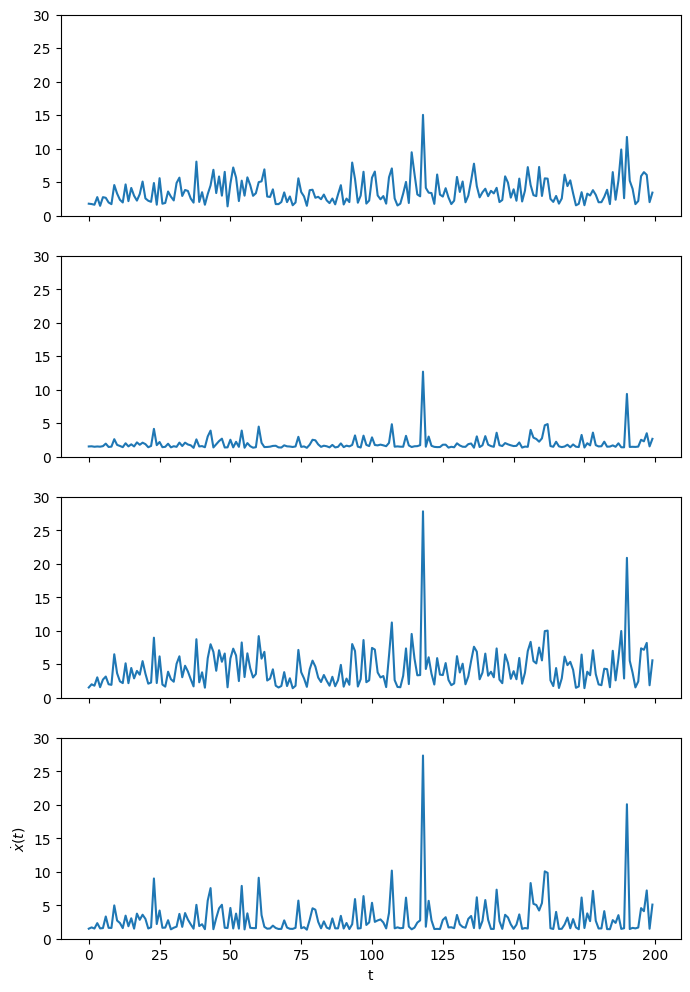

In [47]:
fig, ax = plt.subplots(nrows=4, figsize=(8, 12), sharex=True, sharey=True)
for i, elt in enumerate(mag_dxs):
    ax[i].plot(elt)
ax[-1].set_ylim(0, 30)
ax[-1].set_xlabel("t")
ax[-1].set_ylabel(r'$\dot{x}(t)$')
plt.show()